In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load MNIST data, preprocessing involves flattening and rescaling range from 0-1

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

def preprocess_data(x_train, x_test):
    
    x_train_p = x_train / 255.0
    x_test_p = x_test / 255.0
    
    sxtrain = np.shape(x_train_p)
    sxtest = np.shape(x_test_p)
    x_train_p = np.reshape(x_train_p, newshape=(sxtrain[0], np.prod(sxtrain[1:])))
    x_test_p = np.reshape(x_test_p, newshape=(sxtest[0], np.prod(sxtest[1:])))
                          
    return x_train_p, x_test_p

training_dataset, validation_dataset = preprocess_data(x_train, x_test)

In [3]:
class Vae:
    
    def loss_function(self):
        
        # KL-divergence between 2 multivariate gaussians
        KL_term = -1*tf.reduce_sum((self.log_sigma_2_z - tf.pow(self.mu_z,2) - tf.exp(self.log_sigma_2_z) + 1)/2, 
                                axis = -1)
        
        # Reconstruction loss - Since our output at each pixel is Bernaoulli, we use the binary cross-entropy loss 
        recon_term = -1*tf.reduce_sum(self.X * tf.log(self.X_decoder_op + self.eps) + (1-self.X) * tf.log(1-self.X_decoder_op + self.eps), 
                                   axis = -1)
        
        batch_loss = tf.reduce_mean(KL_term + recon_term)
        
        return batch_loss
    
    def sample_from_Q(self):
        
        epsilon = tf.random_normal(shape = tf.shape(self.mu_z), mean = 0.0, stddev=1.0)
        
        # Reparametrization
        samps = self.mu_z + tf.sqrt(tf.exp(self.log_sigma_2_z)) * epsilon
             
        return samps
        
    
    def __init__(self, im_pixels, encoder_dims, latent_dim, decoder_dims, gamma, learning_rate):
        
        self.X = tf.placeholder(tf.float32, shape = [None] + [im_pixels], name = 'X')
        self.enc_units = encoder_dims
        self.dec_units = decoder_dims
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.eps = 1e-16 # For numerical stability on log operation
        
        #encoder
        
        W = tf.Variable(tf.truncated_normal(shape=(im_pixels, self.enc_units[0]), stddev=0.1),
                                            name='Weight_enc_0')
        b = tf.Variable(tf.zeros(shape=(self.enc_units[0])), name='bias_enc_0')
        
        self.encoding_op = tf.nn.relu(tf.matmul(self.X, W) + b)
        
        for i in range(1, len(self.enc_units)):
            
            W = tf.Variable(tf.truncated_normal(shape=(self.enc_units[i-1], self.enc_units[i]), stddev=0.1),
                                            name='Weight_enc_{0}'.format(i))
            b = tf.Variable(tf.zeros(shape=(self.enc_units[i])), name='bias_enc_{0}'.format(i))
            
            self.encoding_op = tf.nn.relu(tf.matmul(self.encoding_op, W) + b)
            
        W = tf.Variable(tf.truncated_normal(shape=(self.enc_units[-1], 2*latent_dim), stddev=0.1),
                                            name='Weight_enc_last')
        b = tf.Variable(tf.zeros(shape=(2*latent_dim)), name='bias_enc_last')
        
        self.encoding_op = tf.matmul(self.encoding_op, W) + b
            
        
        # Sample epsilon from N(0,I) to indirectly sample from Q(z|x) - Reparametrization trick
        
        self.mu_z = self.encoding_op[:,:latent_dim]
        self.log_sigma_2_z = self.encoding_op[:,latent_dim:]
        
        self.Z = self.sample_from_Q()
        
        W = tf.Variable(tf.truncated_normal(shape=(latent_dim, self.dec_units[0]), stddev=0.1),
                                            name='Weight_dec_0')
        b = tf.Variable(tf.zeros(shape=(self.dec_units[0])), name='bias_dec_0')
        
        self.decoding_op = tf.nn.relu(tf.matmul(self.Z, W) + b)
        
        for j in range(1, len(self.dec_units)):
            W = tf.Variable(tf.truncated_normal(shape=(self.dec_units[j-1], self.dec_units[j]), stddev=0.1),
                                            name='Weight_dec_{0}'.format(j))
            b = tf.Variable(tf.zeros(shape=(self.dec_units[j])), name='bias_dec_{0}'.format(j))
            
            self.decoding_op = tf.nn.relu(tf.matmul(self.decoding_op, W) + b)
            
        W = tf.Variable(tf.truncated_normal(shape=(self.dec_units[-1], im_pixels), stddev=0.1),
                                            name='Weight_dec_last')
        b = tf.Variable(tf.zeros(shape=(im_pixels)), name='bias_dec_last')
        
        self.X_decoder_op = tf.nn.sigmoid(tf.matmul(self.decoding_op, W) + b)
        
        self.reg_loss = sum(tf.nn.l2_loss(tf_var)
                for tf_var in tf.trainable_variables()
                if not ("bias" in tf_var.name))
        
        self.loss = self.loss_function()
        self.loss = self.loss + self.gamma*self.reg_loss
        
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        
        self.train_step = optimizer.minimize(self.loss)
        
        self.session = tf.Session()
        self.session.run(tf.global_variables_initializer())
 

In [4]:
#Create pipeline for dataset

dataset_train = tf.data.Dataset.from_tensor_slices(training_dataset)
batch_size = tf.placeholder(tf.int64)

dataset_train = dataset_train.shuffle(buffer_size=len(training_dataset[0])).batch \
                                    (batch_size = batch_size).repeat()
iterator_train = dataset_train.make_initializable_iterator()
next_batch_train = iterator_train.get_next()

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
bsize = 256
im_pixels = training_dataset.shape[-1]
encoder_dims = [512, 256, 128]
decoder_dims = encoder_dims[::-1]

latent_dim = 4

learning_rate = 0.0007
gamma = 0.001

n_steps = 5000
val_interval = 50

In [6]:
sess = tf.Session()
sess.run(iterator_train.initializer, feed_dict = {batch_size: bsize})

In [7]:
mnist_vae = Vae(im_pixels, encoder_dims, latent_dim, decoder_dims, gamma, learning_rate)

Instructions for updating:
Use tf.cast instead.


In [8]:
train_loss_list = []
print("Iter \t Train_Loss \t Val_Loss")
for t in range(n_steps):
    train_batch = sess.run(next_batch_train)
    feed_dict = {mnist_vae.X : train_batch}
    train_loss, _ = mnist_vae.session.run([mnist_vae.loss, mnist_vae.train_step], feed_dict=feed_dict)
    train_loss_list.append(train_loss)

    if t % val_interval == 0:
            val_dict = {mnist_vae.X: validation_dataset}
            val_loss = mnist_vae.session.run(mnist_vae.loss, feed_dict=val_dict)
            
            print("{0} \t {1:.3f} \t {2:.3f}".format(t,train_loss,val_loss))

Iter 	 Train_Loss 	 Val_Loss
0 	 556.162 	 545.580
50 	 214.073 	 208.896
100 	 188.752 	 190.643
150 	 167.928 	 171.589
200 	 162.481 	 162.427
250 	 159.453 	 156.404
300 	 151.350 	 152.776
350 	 152.925 	 149.676
400 	 148.234 	 148.110
450 	 146.624 	 146.386
500 	 151.358 	 145.978
550 	 138.586 	 143.991
600 	 142.935 	 142.838
650 	 143.912 	 142.312
700 	 143.131 	 141.188
750 	 140.960 	 140.248
800 	 136.757 	 139.640
850 	 137.653 	 139.254
900 	 138.529 	 139.252
950 	 132.191 	 138.302
1000 	 134.952 	 138.151
1050 	 141.322 	 137.155
1100 	 137.791 	 136.649
1150 	 135.481 	 136.971
1200 	 134.497 	 136.589
1250 	 133.786 	 135.821
1300 	 135.267 	 135.749
1350 	 137.659 	 135.564
1400 	 135.416 	 135.577
1450 	 132.080 	 134.778
1500 	 135.048 	 134.797
1550 	 138.169 	 134.567
1600 	 139.545 	 134.252
1650 	 132.769 	 134.051
1700 	 137.308 	 133.825
1750 	 136.265 	 133.694
1800 	 137.213 	 133.263
1850 	 137.727 	 133.259
1900 	 132.397 	 132.844
1950 	 135.160 	 13

In [9]:
# Hallucinate samples, sample from the prior and feed in the latent variable through feed_dict.

imshape = x_train.shape[-1]
n_samples = 10
prior_samples = np.random.normal(size = (n_samples, latent_dim))
f_dict = {mnist_vae.Z : prior_samples}
hal = mnist_vae.session.run(mnist_vae.X_decoder_op, feed_dict = f_dict)

hal_images = np.reshape(hal, (n_samples, imshape, imshape))


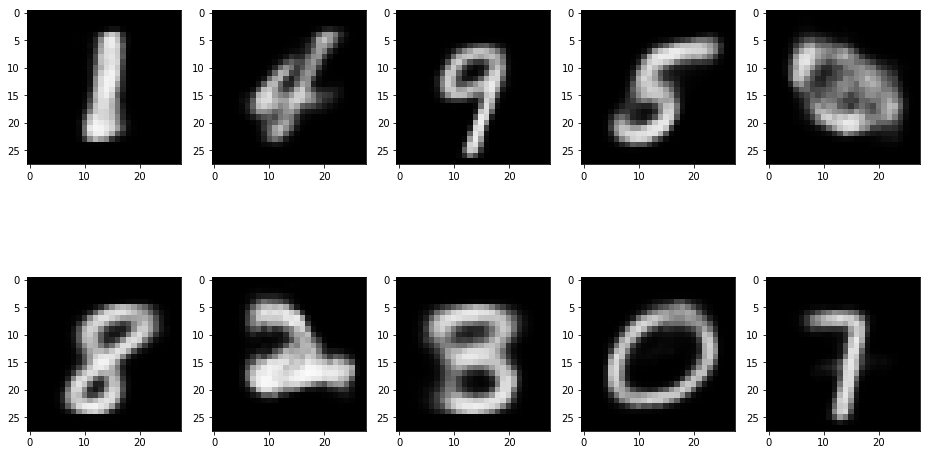

In [10]:
plt.figure(figsize=(16,9))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.imshow(hal_images[i-1], cmap='gray', vmin=0.0, vmax=1.0)

